In [ ]:
import pandas as pd

indexes = []
all_indexes = {}

all_indexes = pd.read_excel('../Data/Index_Data.xlsx', sheet_name=None)

for sheet_name, df in all_indexes.items():
    indexes.append(sheet_name)
    all_indexes[sheet_name] = df

BSESN = all_indexes['BSESN']
BSESN.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price,Momentum_Indicator,High_Low_Change,High_Open_Change,Low_Open_Change,Day,Month,Year
6803,2025-02-11 00:00:00+05:30,77384.976562,77387.281250,76030.593750,76293.601562,9800,0,0,-0.013170,-0.014103,0.017844,0.000030,-0.017502,11,2,2025
6804,2025-02-12 00:00:00+05:30,76188.242188,76459.718750,75388.390625,76171.078125,10400,0,0,-0.001606,-0.000225,0.014211,0.003563,-0.010498,12,2,2025
6805,2025-02-13 00:00:00+05:30,76201.101562,76764.531250,76013.429688,76138.968750,6900,0,0,-0.000422,-0.000815,0.009881,0.007394,-0.002463,13,2,2025
6806,2025-02-14 00:00:00+05:30,76388.992188,76483.062500,75439.640625,75939.210938,9300,0,0,-0.002624,-0.005888,0.013831,0.001231,-0.012428,14,2,2025
6807,2025-02-17 00:00:00+05:30,75641.406250,76041.960938,75294.757812,75996.859375,0,0,0,0.000759,0.004699,0.009924,0.005295,-0.004583,17,2,2025


In [4]:
# !pip install prophet

In [ ]:
from prophet import Prophet
import numpy as np

In [6]:
df = pd.DataFrame()
df['Date'] = BSESN['Date']
df['Close'] = BSESN['Close']

df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_localize(None)
df.dropna(inplace=True)
df.tail()

,Date,Close
6803,2025-02-11,76293.601562
6804,2025-02-12,76171.078125
6805,2025-02-13,76138.968750
6806,2025-02-14,75939.210938
6807,2025-02-17,75996.859375


In [7]:
df.isna().sum()

,0
Date,0
Close,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6808 entries, 0 to 6807
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6808 non-null   datetime64[ns]
 1   Close   6808 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 106.5 KB


In [9]:
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df.tail()

,ds,y
6803,2025-02-11,76293.601562
6804,2025-02-12,76171.078125
6805,2025-02-13,76138.968750
6806,2025-02-14,75939.210938
6807,2025-02-17,75996.859375


In [10]:
train = df[:-365]
test = df[-365:]

In [11]:
train.shape, test.shape

((6443, 2), (365, 2))

In [12]:
model = Prophet()
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu03i5bio/00yhzcb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu03i5bio/pan0w2du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6946', 'data', 'file=/tmp/tmpu03i5bio/00yhzcb0.json', 'init=/tmp/tmpu03i5bio/pan0w2du.json', 'output', 'file=/tmp/tmpu03i5bio/prophet_modele4fdwylm/prophet_model-20250413170155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)

In [14]:
test_df = pd.DataFrame({"test":test['y']})
test_df = test_df.reset_index(drop=True)

predicted_df = pd.DataFrame({"forecast":forecast['yhat'][-365:]})
predicted_df = predicted_df.reset_index(drop=True)

In [15]:
comparison_df = pd.concat([test_df, predicted_df], axis=1)
comparison_df['difference'] = comparison_df['test'] - comparison_df['forecast']
comparison_df

,test,forecast,difference
0,65252.339844,63895.780821,1356.559022
1,64886.511719,63868.943440,1017.568279
2,64996.601562,64445.861399,550.740163
3,65075.820312,64464.434078,611.386235
4,65087.250000,63950.513567,1136.736433
...,...,...,...
360,76293.601562,70461.710613,5831.890949
361,76171.078125,69939.074740,6232.003385
362,76138.968750,69952.914564,6186.054186
363,75939.210938,69960.605775,5978.605163


In [16]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(comparison_df['test'], comparison_df['forecast'])

print(f"MAE: {mae}")

MAE: 7787.145409394834


In [ ]:
def calculate_r_squared(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_mean = np.mean(y_true)

    # Total sum of squares (TSS)
    tss = np.sum((y_true - y_mean) ** 2)

    # Residual sum of squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)

    # Calculate R-squared
    r_squared = 1 - (rss / tss)

    return r_squared

calculate_r_squared(comparison_df['test'], comparison_df['forecast'])

np.float64(-1.4997307177291672)

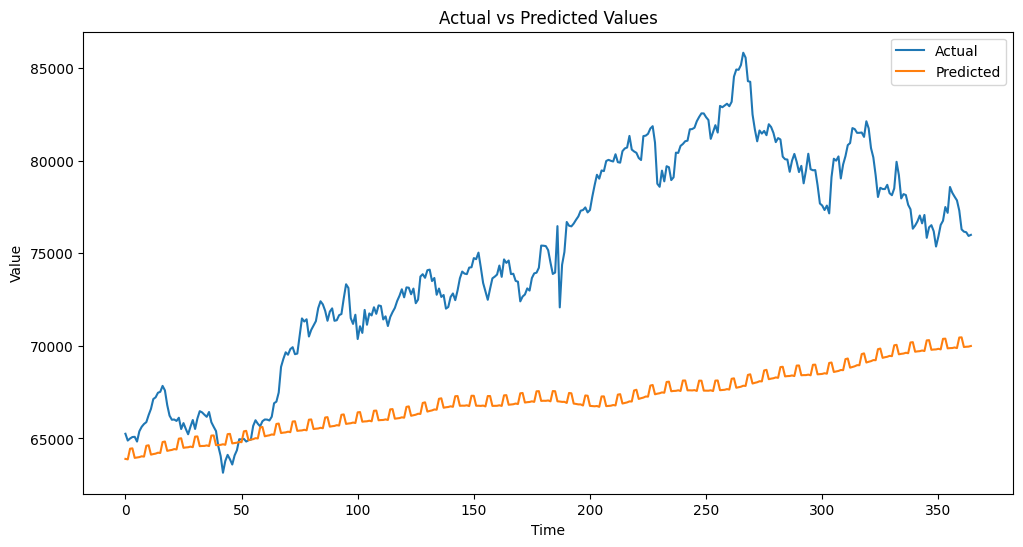

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['test'], label='Actual')
plt.plot(comparison_df['forecast'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()